# Library

In [1]:
import numpy as np
import torch
import gpytorch
import argparse
import time
import pickle
import scipy.io as sio

from torch.distributions import Normal
import matplotlib.pyplot as plt
import random

import roslib
import rospy
import tf as tf_ros
from nav_msgs.msg import Odometry, Path
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from geometry_msgs.msg import PoseStamped, PoseArray, Pose
import math
import cv2
import copy

import sys
sys.path.append('..')

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


## Check GPU

In [2]:
import torch
import sys
sys.path.append('..')
from torchlib.utils import list_device,set_device

list_device()

------------ List Devices ------------
Device 0 :
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB

Device 1 :
TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB



## Set torch default parameters

In [3]:
set_device(1)
import numpy as np
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=2)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [4]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=300, help='size of mini batch')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/gps_grid_torch', help='rnn, gru, or lstm')

parser.add_argument('--test_dataset', type=str, default=[# '/notebooks/michigan_nn_data/2012_01_08',
                                                         # '/notebooks/michigan_nn_data/2012_01_15',
                                                         # '/notebooks/michigan_nn_data/2012_01_22',
                                                         # '/notebooks/michigan_nn_data/2012_02_02',
                                                         # '/notebooks/michigan_nn_data/2012_02_04',
                                                         # '/notebooks/michigan_nn_data/2012_02_05',
                                                         '/notebooks/michigan_nn_data/2012_02_12',
                                                         # '/notebooks/michigan_nn_data/2012_03_31',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         # '/notebooks/michigan_nn_data/2012_09_28'])
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'
                                                        ] )

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

#parser.add_argument('--map_dataset', type=str, default='/home/kevin/data/michigan_gt/training')
parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--enable_ros', type=bool, default=False, help='put data into ros')

sys.argv = ['']
args = parser.parse_args()

if args.enable_ros:
    rospy.init_node('global_localization_tf_broadcaster_cnn')

# Load Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
#from PIL import Image
import numpy as np
import random

#
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet, cnn_auxiliary
from torchlib.cnn_auxiliary import normalize, denormalize, denormalize_navie, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False, mode='evaluate')

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)

    
dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=0, \
                        drop_last=False, pin_memory=True)

100%|██████████| 12683/12683 [00:16<00:00, 762.40it/s]


Load norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

In [8]:
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid.pkl'))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)
        
grid = Grid()

filename = os.path.join(args.model_dir,'grid.pkl')
with open(filename,'rb') as f:
    dataPickle = f.read()
    grid = pickle.loads(dataPickle)

In [58]:
grid.overlap = 0
grid.num_grid_x,grid.num_grid_y = grid._cal_grid_num()
grid.grid_range_x,grid.grid_range_y = grid._cal_grid_range()

In [62]:
grid.in_grids(0,100)

[6, 6, 6, 6]

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

X = np.array(dataset.Targets)[:,:2]
X = np.vstack([X,X+np.random.rand(91940, 2)*10])
label_mask = np.zeros([X.shape[0],4])
for i in range(X.shape[0]):
    label_mask[i] = np.array(grid.in_grids(*X[i]))

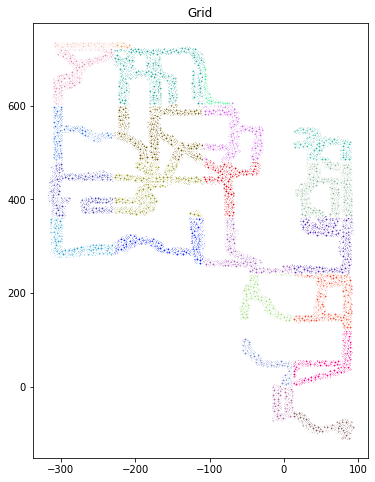

In [64]:
r = lambda: np.random.randint(0,255)
colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(grid.num_grid), colors):
    my_members = np.sum(label_mask == k,axis=1) >= 1
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
ax.set_title('Grid')
plt.show()

# Global GP

In [15]:
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet.resnet50(pretrained=True)
    def forward(self,input_data):
        dense_feat = self.resnet(input_data)
        return dense_feat
    
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.global_context = vggnet.vggnet(input_channel=2048,opt="context")
        self.global_regressor = vggnet.vggnet(opt="regressor")
        
    def forward(self,input_data):
        context_feat = self.global_context(input_data)
        output,feature_t, feature_r = self.global_regressor(context_feat)
        return output, feature_t, feature_r

class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([1])),
            batch_shape=torch.Size([1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        inducing_points = torch.zeros(3, args.batch_size, 128)
        self.backbone = Backbone()
        self.nn = NN()
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
        
    def forward(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention 
        trans_pred = self.gp(feature_t)
        return trans_pred, rot_pred
    
class Trainer:
    def __init__(self,regressor_context_rate = [0.0,0.0]):
        # data
        self.model = Model().cuda()
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
        # disable learning backbone
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
        '''
        # training tool
        self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
        self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                         lr_lambda=lambda epoch: args.decay_rate**epoch)
        '''
        # or use `gpytorch.mlls.VariationalELBO`
        num_data = min(len(dataloader)*args.batch_size,len(dataset))
        self.mll = gpytorch.mlls.PredictiveLogLikelihood(self.model.likelihood, \
                                                         self.model.gp, num_data = num_data)
        
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            state_dict = self._from_old_model(state_dict)
        print('Parameters layer:',len(state_dict.keys()))
        # load file to model
        self.model.load_state_dict(state_dict,strict = True)
        # Display model structure
        for name, param in self.model.named_parameters():
            print(name, param.shape)
        print('Parameters layer:',len(self.model.state_dict().keys()))
        # check load
        assert len(state_dict.keys()) == len(self.model.state_dict().keys())
    
    def _from_old_model(self, state_dict):
        for key in list(state_dict):
            if 'net.resnet.' in key:
                state_dict[key.replace('net.resnet.','backbone.resnet.')] = state_dict.pop(key)
            elif 'net.global_regressor.' in key:
                state_dict[key.replace('net.global_regressor.','nn.global_regressor.')] = state_dict.pop(key)
            elif 'net.global_context.' in key:
                state_dict[key.replace('net.global_context.','nn.global_context.')] = state_dict.pop(key)
        return state_dict
         
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
  
    def _optimize(self,regressor_context_rate = [0.0,0.0]):
        optimizer = [
                {'params': self.model.gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay},
                {'params': self.model.likelihood.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            for param in self.model.nn.global_regressor.parameters():
                param.requires_grad = False
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            for param in self.model.nn.global_context.parameters():
                param.requires_grad = False
                
        return optimizer
    
    def train(self,x, y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        
        start = time.time()
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std)
            
        # Step 2: training
        assert trainer.model.training == True
        single_loss = self._loss(x, y)
        batch_time = time.time() - start
        
        #Step 3: update
        single_loss.backward()
        self.optimizer.step()
        
        return float(single_loss), batch_time
            
    def _loss(self,x, y):
        # target
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        # predict
        trans_pred, rot_pred = self.model(x)
        
        # trans loss
        trans_loss = -1.*self.mll(trans_pred, trans_target)
        # rot loss
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        
        total_loss = trans_loss + args.lamda_weights * rot_loss      
        
        return total_loss
    
    def eval_forward(self,x,y,num_sample = 100,output_denormalize = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std)
        
        # Step 2: forward
        assert trainer.model.training == False
        trans_prediction, rot_prediction = self.model(x)
        trans_prediction, trans_mean, trans_var = self._eval_gp(trans_prediction)
        
        if args.is_normalization and output_denormalize:
            trans_prediction = denormalize_navie(trans_prediction, self.norm_mean, self.norm_std)
            trans_mean = denormalize_navie(trans_mean, self.norm_mean, self.norm_std)
            trans_var = trans_var.mul(self.norm_std)
            y = denormalize(y, self.norm_mean, self.norm_std)
        
        samples = self._sample(trans_mean, trans_var, num_sample)
            
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_prediction, rot_prediction, trans_target, rot_target, samples
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def _eval_gp(self, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = self.model.likelihood(trans_pred).mean, self.model.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
global_trainer = Trainer()
global_trainer.load_model('/notebooks/global_localization/gp_net_torch/pretrained.pth')
global_trainer.model.eval()

Transform from old model.
Parameters layer: 356
backbone.resnet.conv1.weight torch.Size([64, 1, 7, 7])
backbone.resnet.bn1.weight torch.Size([64])
backbone.resnet.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.resnet.layer1.0.bn1.weight torch.Size([64])
backbone.resnet.layer1.0.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.resnet.layer1.0.bn2.weight torch.Size([64])
backbone.resnet.layer1.0.bn2.bias torch.Size([64])
backbone.resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.bn3.weight torch.Size([256])
backbone.resnet.layer1.0.bn3.bias torch.Size([256])
backbone.resnet.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.downsample.1.weight torch.Size([256])
backbone.resnet.layer1.0.downsample.1.bias torch.Size([256])
backbone.resnet.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.resnet.layer1.1.bn1.weight to

Model(
  (backbone): Backbone(
    (resnet): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1)

In [16]:
for param in global_trainer.model.parameters():
    param.requires_grad = False

# Define Model

In [17]:
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet.resnet50(pretrained=True)
    def forward(self,input_data):
        dense_feat = self.resnet(input_data)
        return dense_feat
    
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.global_context = vggnet.vggnet(input_channel=2048,opt="context")
        self.global_regressor = vggnet.vggnet(opt="regressor")
        
    def forward(self,input_data):
        context_feat = self.global_context(input_data)
        output,feature_t, feature_r = self.global_regressor(context_feat)
        return output, feature_t, feature_r

class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_dim]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_dim])),
            batch_shape=torch.Size([output_dim]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPNode(nn.Module):
    def __init__(self,inducing_points):
        super().__init__()
        output_dim = inducing_points.shape[0]
        feat_dim = inducing_points.shape[-1]
        assert output_dim == args.output_dim
        assert feat_dim == args.feat_dim
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output
    
class Model(nn.Module):
    def __init__(self,num_grid):
        super().__init__()
        self.backbone = Backbone()
        self.nn = NN()
        self.gps = nn.ModuleList()
        
        self.num_gp = num_grid
        
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            gp = GPNode(inducing_points)
            self.gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred

In [65]:
class Trainer:
    def __init__(self,grid,is_training=True,regressor_context_rate = [0.0,0.0]):
        self.model = Model(grid.num_grid).cuda()
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
        # disable learning backbone
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            # disable all learning
            for param in self.model.parameters():
                param.requires_grad = False
        
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        print('Model Structure:')
        # Display model structure
        for name, param in self.model.named_parameters():
            print(name, param.shape)
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def _optimize(self,regressor_context_rate = [0.0,0.0]):
        optimizer = [
                {'params': self.model.gps.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            for param in self.model.nn.global_regressor.parameters():
                param.requires_grad = False
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            for param in self.model.nn.global_context.parameters():
                param.requires_grad = False
                
        return optimizer
            
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        
        start = time.time()
        # Step 1: get data
        #labels = torch.from_numpy(pairwise_distances_argmin(y[:,:2].numpy(), mbk_means_cluster_centers)).cuda()
        label = np.zeros([y.shape[0],4])
        for i in range(y.shape[0]):
            label[i] = np.array(grid.in_grids(*y[i,:2]))
        
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim       
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        trans_feat, rot_pred = self.model.forward_nn(x)
        rot_loss = self._nn_loss(rot_pred,rot_target)
        
        gps_loss = np.zeros(self.model.num_gp)
        for i,gp in enumerate(self.model.gps):
            num_data = dis[i]
            if num_data > 0:
                label_mask = np.sum(label == i,axis=1) >= 1
                sub_x = trans_feat[label_mask]
                sub_y = trans_target[label_mask] # unnormalized data 
                if sub_y.shape[0]>0:
                    gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                    gps_loss[i] = float(gp_loss)
                    trans_loss += gp_loss #* int(sub_y.shape[0])/args.batch_size
        trans_loss = trans_loss/self.model.num_gp
        total_loss = trans_loss + args.lamda_weights * rot_loss
        
        #Step 3: update
        total_loss.backward()
        self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), batch_time, gps_loss
    
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        # predict
        trans_pred = self.model.forward_gp(gp,trans_feat)
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, num_data = num_data)
        
        # trans loss
        trans_loss = -1.*mll(trans_pred, trans_target)
        
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples

    def eval_forward(self,x,y,num_sample = 100,output_denormalize = True,label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            #labels = pairwise_distances_argmin(y[:,:2].cpu().numpy(), mbk_means_cluster_centers)
            
            labels = np.zeros([y.shape[0],4])
            for i in range(y.shape[0]):
                labels[i] = np.array(grid.in_grids(*y[i,:2].cpu().numpy()))
        else:
            global_trans_pred,_ = global_trainer.model(x)
            global_trans_pred, _, _ = global_trainer._eval_gp(global_trans_pred)
            global_trans_pred = denormalize_navie(global_trans_pred, global_trainer.norm_mean, global_trainer.norm_std)
            
            #labels = pairwise_distances_argmin(global_trans_pred[:,:2].cpu().numpy(), mbk_means_cluster_centers)
            labels = np.zeros([y.shape[0],4])
            for i in range(y.shape[0]):
                labels[i] = np.array(grid.in_grids(*global_trans_pred[i,:2].cpu().numpy()))
        
        labels = labels[:,0] 
        
        #if args.is_normalization:
        #    y = normalize(y,self.norm_mean, self.norm_std)
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()

        for i,gp in enumerate(trainer.model.gps):
            label_mask = labels == i
            #label_mask = np.sum(labels == i,axis=1) >= 1
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
        
        #if args.is_normalization and output_denormalize:
        #    y = denormalize(y, self.norm_mean, self.norm_std)
        
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

trainer = Trainer(grid,is_training=False)
#trainer = Trainer(grid,regressor_context_rate = [0.1,0.])

trainer.load_model('pretrained.pth')
#trainer.load_model('model-3-1500.pth')
#trainer.load_model('model-2-1000.pth')

Parameters layer: 666
Model Structure:
backbone.resnet.conv1.weight torch.Size([64, 1, 7, 7])
backbone.resnet.bn1.weight torch.Size([64])
backbone.resnet.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.resnet.layer1.0.bn1.weight torch.Size([64])
backbone.resnet.layer1.0.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.resnet.layer1.0.bn2.weight torch.Size([64])
backbone.resnet.layer1.0.bn2.bias torch.Size([64])
backbone.resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.bn3.weight torch.Size([256])
backbone.resnet.layer1.0.bn3.bias torch.Size([256])
backbone.resnet.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.downsample.1.weight torch.Size([256])
backbone.resnet.layer1.0.downsample.1.bias torch.Size([256])
backbone.resnet.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.resnet.layer1.1.bn1.weight torch.Size(

In [66]:
for param in trainer.model.parameters():
    param.requires_grad = False

# Initialize

In [71]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

In [72]:
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward(x,y,label_from_gp = False)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

300/92100, translation error = 3.117, rotation error = 2.782, time/batch = 0.795
600/92100, translation error = 7.826, rotation error = 3.438, time/batch = 0.772
900/92100, translation error = 7.960, rotation error = 3.386, time/batch = 0.780
1200/92100, translation error = 6.860, rotation error = 3.444, time/batch = 0.779
1500/92100, translation error = 6.128, rotation error = 3.554, time/batch = 0.767
1800/92100, translation error = 5.417, rotation error = 3.540, time/batch = 0.772
2100/92100, translation error = 5.169, rotation error = 3.675, time/batch = 0.781
2400/92100, translation error = 4.759, rotation error = 3.582, time/batch = 0.772
2700/92100, translation error = 4.569, rotation error = 3.701, time/batch = 0.781
3000/92100, translation error = 4.422, rotation error = 3.717, time/batch = 0.772
3300/92100, translation error = 4.159, rotation error = 3.600, time/batch = 0.779
3600/92100, translation error = 4.097, rotation error = 3.625, time/batch = 0.775
3900/92100, transla

30300/92100, translation error = 6.828, rotation error = 5.052, time/batch = 0.781
30600/92100, translation error = 6.788, rotation error = 5.039, time/batch = 0.795
30900/92100, translation error = 6.737, rotation error = 5.031, time/batch = 0.782
31200/92100, translation error = 6.698, rotation error = 5.040, time/batch = 0.782
31500/92100, translation error = 6.653, rotation error = 5.021, time/batch = 0.784
31800/92100, translation error = 6.611, rotation error = 5.000, time/batch = 0.790
32100/92100, translation error = 6.574, rotation error = 4.985, time/batch = 0.780
32400/92100, translation error = 6.534, rotation error = 4.977, time/batch = 0.794
32700/92100, translation error = 6.491, rotation error = 4.969, time/batch = 0.785
33000/92100, translation error = 6.445, rotation error = 4.953, time/batch = 0.780
33300/92100, translation error = 6.412, rotation error = 4.936, time/batch = 0.800
33600/92100, translation error = 6.378, rotation error = 4.925, time/batch = 0.778
3390

60000/92100, translation error = 7.431, rotation error = 5.276, time/batch = 0.797
60300/92100, translation error = 7.405, rotation error = 5.267, time/batch = 0.786
60600/92100, translation error = 7.384, rotation error = 5.263, time/batch = 0.785
60900/92100, translation error = 7.361, rotation error = 5.255, time/batch = 0.783
61200/92100, translation error = 7.346, rotation error = 5.251, time/batch = 0.784
61500/92100, translation error = 7.394, rotation error = 5.274, time/batch = 0.782
61800/92100, translation error = 7.641, rotation error = 5.408, time/batch = 0.782
62100/92100, translation error = 7.616, rotation error = 5.404, time/batch = 0.781
62400/92100, translation error = 7.595, rotation error = 5.400, time/batch = 0.787
62700/92100, translation error = 7.570, rotation error = 5.393, time/batch = 0.788
63000/92100, translation error = 7.545, rotation error = 5.390, time/batch = 0.779
63300/92100, translation error = 7.552, rotation error = 5.405, time/batch = 0.835
6360

89700/92100, translation error = 9.089, rotation error = 6.570, time/batch = 0.829
90000/92100, translation error = 9.153, rotation error = 6.576, time/batch = 0.811
90300/92100, translation error = 9.128, rotation error = 6.564, time/batch = 0.792
90600/92100, translation error = 9.115, rotation error = 6.561, time/batch = 0.839
90900/92100, translation error = 9.096, rotation error = 6.555, time/batch = 0.832
91200/92100, translation error = 9.086, rotation error = 6.586, time/batch = 0.821
91500/92100, translation error = 9.070, rotation error = 6.664, time/batch = 0.799
91800/92100, translation error = 9.046, rotation error = 6.654, time/batch = 0.793
92100/92100, translation error = 9.039, rotation error = 6.655, time/batch = 0.381


median translation error = 2.182
median rotation error = 3.162
mean translation error = 9.039
mean rotation error = 6.655


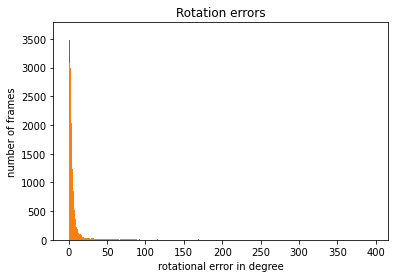

In [74]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [34]:
def evaluate(trans_errors,rot_errors):
    t = [14301,7008,12852,9567,13580,14835,7114,12683]
    for i in range(len(t)):
        if i >0:
            t[i] += t[i-1]
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== var translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("var translation error = {:.3f}".format(np.var(trans_errors_i)))
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== var translation error ==================
var translation error = 410.225
var translation error = 436.164
var translation error = 2592.519
var translation error = 2986.038
var translation error = 2083.001
var translation error = 3222.961
var translation error = 2796.318
var translation error = 3001.272
================== median translation error ==================
median translation error = 1.727
median translation error = 1.772
median translation error = 2.072
median translation error = 2.057
median translation error = 2.165
median translation error = 2.220
median translation error = 3.684
median translation error = 3.122
================== median rotation error ==================
median rotation error = 2.600
median rotation error = 2.830
median rotation error = 2.998
median rotation error = 2.957
median rotation error = 3.196
median rotation error = 3.324
median rotation error = 4.470
median rotation error = 4.182
================== mean translation error =========